Firstly import the required packages. We are using pandas to read csv files here, so import pandas.

In [3]:
import numpy as np
import pandas as pd

We will be loading the complete MNIST csv file which includes features and labels, then split it.
You can download the test data from this link:
https://pjreddie.com/projects/mnist-in-csv/

In [7]:
mnist = pd.read_csv('C:/Users/Nihar/Desktop/mnist_test.csv', sep=',')
mnist_arr = mnist.values

Split sample features and labels into X and y

In [8]:
X = mnist_arr[:,1:]
y = mnist_arr[:,0]

Put these images into pandas dataframes, this meakes it very easy for us plot them in the future.
More details here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [10]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))


Size of the dataframe: (9999, 785)


The images from the csv are sequentially ordered wrt the digits, so we will be permuting them first and then pick 30 samples from it.

In [11]:
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

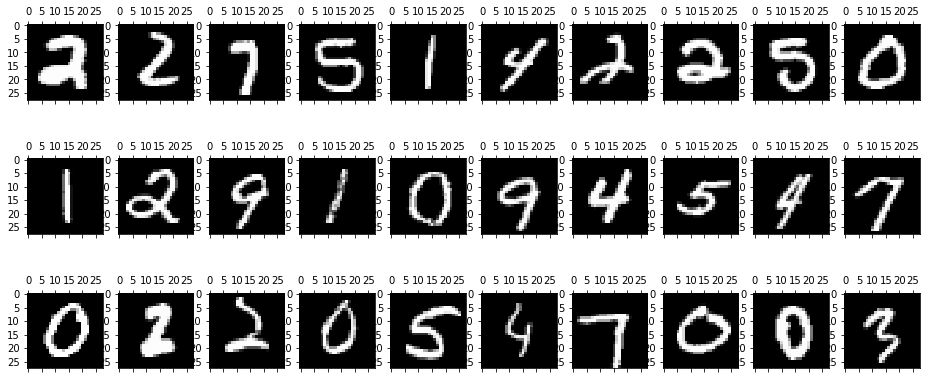

In [14]:
import matplotlib.pyplot as plt
# More details here https://matplotlib.org/api/pyplot_api.html
# Plot the graph
plt.gray()
fig = plt.figure(figsize=(16,7))
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1)#, title='Digit: ' + str(df.loc[rndperm[i],'label']))
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

Now, it is time to see how t-SNE works. But before we do that, we need to know that t-SNE is computationally heavy and therefore we are limited on the applications for this.

Because of the computational issues, we will first be reducing the dimensionality of the dataset before we use t-SNE on it. This reduces the work load on the system and also allows us to run this in class!

So before we get into t-SNE, we see how PCA works. 

In [22]:
from sklearn.decomposition import PCA
# More details here http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.10048016 0.0754375  0.06141024]


So what we just did above is reduced the dimensionality from 784 to 3. This definitely means that you lost some valuable data, but the point is to see how much of the original variation is retained. As from the results, we can sum it up and tell that about 25% of the variation in the data has been retained. But is this enough to humanly set the digits apart when plotted on a scatterplot?

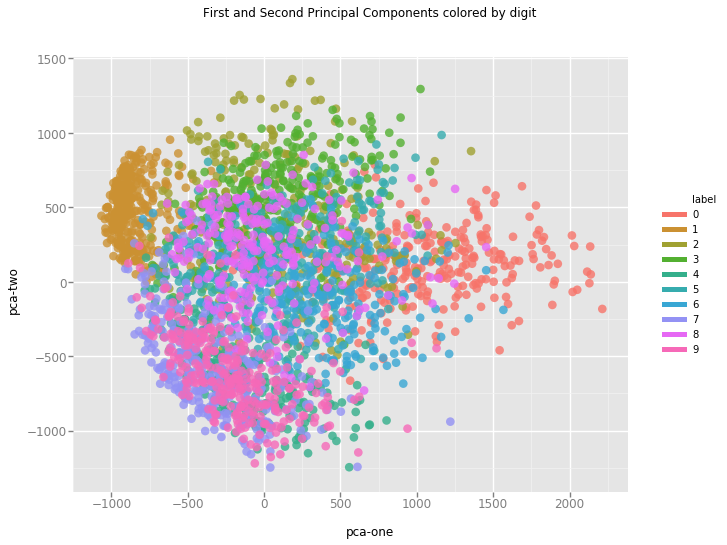

<ggplot: (165909962728)>

In [26]:
# Possible error if you try to import Timestamp from pandas.lib, that is deprecated now
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

For curiosity's sake, let's see how PCA would work if we tried to capture all the variation with 50 dimensions i.e., 784 -> 50

In [30]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8315948622671572


This gives us something amazing isn't it? We captured more than 83% of the variation in the data just by using 50 dimensions, i.e., of the available 784 dimensions, just about 16% of it is required to describe the data with upto 83% accuracy.

In [31]:
import time
from sklearn.manifold import TSNE

n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[rndperm[:n_sne]])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9999 samples in 0.049s...
[t-SNE] Computed neighbors for 9999 samples in 10.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9999
[t-SNE] Computed conditional probabilities for sample 2000 / 9999
[t-SNE] Computed conditional probabilities for sample 3000 / 9999
[t-SNE] Computed conditional probabilities for sample 4000 / 9999
[t-SNE] Computed conditional probabilities for sample 5000 / 9999
[t-SNE] Computed conditional probabilities for sample 6000 / 9999
[t-SNE] Computed conditional probabilities for sample 7000 / 9999
[t-SNE] Computed conditional probabilities for sample 8000 / 9999
[t-SNE] Computed conditional probabilities for sample 9000 / 9999
[t-SNE] Computed conditional probabilities for sample 9999 / 9999
[t-SNE] Mean sigma: 348.767831
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.017181
[t-SNE] Error after 300 iterations: 2.783459
t-SNE done! Time elapsed: 127.9036695957183

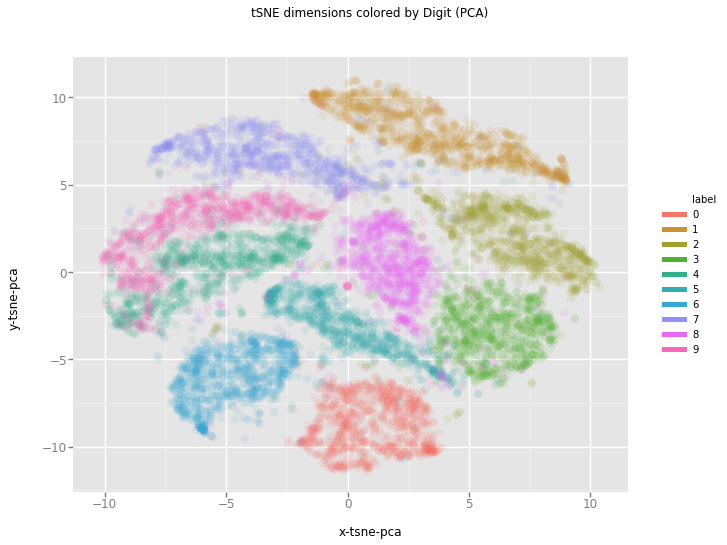

<ggplot: (8779039032937)>

In [101]:
df_tsne = None
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart